In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os

BASE_DIR = "/content/drive/MyDrive/ML_CRISPR_Diabetes"  # change if needed
os.makedirs(BASE_DIR, exist_ok=True)

dirs = {
    "gwas":   os.path.join(BASE_DIR, "data/raw/GWAS"),
    "geno":   os.path.join(BASE_DIR, "data/raw/1000G"),   # kept for completeness
    "ml":     os.path.join(BASE_DIR, "data/raw/UCI"),
    "crispr": os.path.join(BASE_DIR, "data/raw/CRISPR"),
    "results":os.path.join(BASE_DIR, "results"),
    "code":   os.path.join(BASE_DIR, "code"),
}

for d in dirs.values():
    os.makedirs(d, exist_ok=True)

dirs


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


{'gwas': '/content/drive/MyDrive/ML_CRISPR_Diabetes/data/raw/GWAS',
 'geno': '/content/drive/MyDrive/ML_CRISPR_Diabetes/data/raw/1000G',
 'ml': '/content/drive/MyDrive/ML_CRISPR_Diabetes/data/raw/UCI',
 'crispr': '/content/drive/MyDrive/ML_CRISPR_Diabetes/data/raw/CRISPR',
 'results': '/content/drive/MyDrive/ML_CRISPR_Diabetes/results',
 'code': '/content/drive/MyDrive/ML_CRISPR_Diabetes/code'}

In [3]:
# Install extra libraries
!pip install imbalanced-learn xgboost shap biopython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 34.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import os

# -------------------------------------------------------------
# 1. LOAD & CLEAN GWAS DATA
# -------------------------------------------------------------
gwas_path = os.path.join(dirs["gwas"], "DIAMANTE_T2D_Stage1.txt")
gwas = pd.read_csv(gwas_path, sep="\t", dtype=str)

# Convert numeric columns
num_cols = ["P_VALUE", "OR"]
for c in num_cols:
    gwas[c] = pd.to_numeric(gwas[c], errors="coerce")

# Keep only chr10 (DIAMANTE uses 1–22, X, Y, MT — no 'chr10')
gwas_chr10 = gwas[gwas["CHROMOSOME"] == "10"].copy()

# -------------------------------------------------------------
# 2. APPLY SIGNIFICANCE FILTER (p < 5e-6)
# -------------------------------------------------------------
gwas_chr10 = gwas_chr10[gwas_chr10["P_VALUE"] < 5e-6].copy()

# Drop entries with missing OR
gwas_chr10 = gwas_chr10[gwas_chr10["OR"].notna()]
gwas_chr10 = gwas_chr10[gwas_chr10["OR"] > 0]

# -------------------------------------------------------------
# 3. COMPUTE EFFECT SIZE (BETA = ln(OR))
# -------------------------------------------------------------
gwas_chr10["BETA"] = np.log(gwas_chr10["OR"])

# -------------------------------------------------------------
# 4. COMPUTE GWAS WEIGHT: w = -log10(p) * sign(beta)
# -------------------------------------------------------------
gwas_chr10["GWAS_weight_raw"] = -np.log10(gwas_chr10["P_VALUE"]) * np.sign(gwas_chr10["BETA"])

# Normalize to 0–1
w = gwas_chr10["GWAS_weight_raw"]
gwas_chr10["GWAS_weight_norm"] = (w - w.min()) / (w.max() - w.min())

# -------------------------------------------------------------
# 5. SUMMARY
# -------------------------------------------------------------
print("Filtered GWAS chr10 variants:", len(gwas_chr10))

# Identify top SNP (should be rs7903146 in TCF7L2)
top_row = gwas_chr10.loc[gwas_chr10["GWAS_weight_norm"].idxmax()]
print("Top chr10 SNP:", top_row["SNP"], "| Normalized Weight =", round(top_row["GWAS_weight_norm"], 4))

# Show preview
gwas_chr10[
    ["SNP","CHROMOSOME","POSITION","RISK_ALLELE","OR","BETA","P_VALUE","GWAS_weight_norm"]
].head()


Filtered GWAS chr10 variants: 100
Top chr10 SNP: rs4506565 | Normalized Weight = 1.0


,SNP,CHROMOSOME,POSITION,RISK_ALLELE,OR,BETA,P_VALUE,GWAS_weight_norm
1559585,rs3915932,10,80611942,G,1.10,0.095310,4.700000e-08,0.032267
1559586,rs810517,10,80612626,C,1.09,0.086178,2.000000e-07,0.022120
1559587,rs12571751,10,80612637,A,1.09,0.086178,1.800000e-07,0.022859
1559588,rs703982,10,80612727,A,1.09,0.086178,1.400000e-07,0.024620
1573289,rs2798253,10,94192885,C,1.15,0.139762,4.400000e-12,0.097265


In [5]:
# -------------------------------------------------------------
# SAVE FILTERED + BETA + NORMALIZED GWAS WEIGHTS (chr10)
# -------------------------------------------------------------

# Ensure output directory exists
os.makedirs(dirs["gwas"], exist_ok=True)

filtered_gwas_path = os.path.join(
    dirs["gwas"],
    "DIAMANTE_chr10_filtered_with_beta_and_weights.txt"
)

# Save tab-separated
gwas_chr10.to_csv(filtered_gwas_path, sep="\t", index=False)

print("GWAS filtered file saved to:")
print(filtered_gwas_path)


GWAS filtered file saved to:
/content/drive/MyDrive/ML_CRISPR_Diabetes/data/raw/GWAS/DIAMANTE_chr10_filtered_with_beta_and_weights.txt


In [7]:
# -------------------------------------------------------------
# RECOMPUTE / VERIFY GWAS WEIGHTS
# (Safe to re-run in case the user starts notebook from Block 3)
# -------------------------------------------------------------

# Compute raw GWAS weight using standard formula:
#   w = -log10(P) * sign(BETA)
gwas_chr10["GWAS_weight_raw"] = (
    -np.log10(gwas_chr10["P_VALUE"]) * np.sign(gwas_chr10["BETA"])
)

# Safe normalization: handle case where all weights might be identical
w = gwas_chr10["GWAS_weight_raw"].values
w_min, w_max = w.min(), w.max()

if np.isclose(w_max - w_min, 0):
    # If all weights identical → assign zeros
    gwas_chr10["GWAS_weight_norm"] = 0.0
    print("Warning: All GWAS weights identical; normalized weights set to 0.")
else:
    gwas_chr10["GWAS_weight_norm"] = (w - w_min) / (w_max - w_min)

# -------------------------------------------------------------
# PREVIEW TABLE
# -------------------------------------------------------------
gwas_chr10[
    ["SNP","CHROMOSOME","POSITION","RISK_ALLELE",
     "BETA","P_VALUE","GWAS_weight_raw","GWAS_weight_norm"]
].head()


,SNP,CHROMOSOME,POSITION,RISK_ALLELE,BETA,P_VALUE,GWAS_weight_raw,GWAS_weight_norm
1559585,rs3915932,10,80611942,G,0.095310,4.700000e-08,7.327902,0.032267
1559586,rs810517,10,80612626,C,0.086178,2.000000e-07,6.698970,0.022120
1559587,rs12571751,10,80612637,A,0.086178,1.800000e-07,6.744727,0.022859
1559588,rs703982,10,80612727,A,0.086178,1.400000e-07,6.853872,0.024620
1573289,rs2798253,10,94192885,C,0.139762,4.400000e-12,11.356547,0.097265


In [8]:
# -------------------------------------------------------------
# RANK VARIANTS BY NORMALIZED GWAS WEIGHT
# -------------------------------------------------------------

# Ensure correct column exists
if "GWAS_weight_norm" not in gwas_chr10.columns:
    raise KeyError("GWAS_weight_norm not found. Run Block 3 first.")

# Sort descending by normalized weight
gwas_ranked = gwas_chr10.sort_values("GWAS_weight_norm", ascending=False)

# Extract top 20 SNPs
top_snps = gwas_ranked.head(20)

# Summary printout
top_snp = gwas_ranked.iloc[0]
print(
    f"Top SNP on chr10: {top_snp['SNP']} "
    f"(Normalized weight = {top_snp['GWAS_weight_norm']:.4f})"
)

# Show table
top_snps[
    ["SNP","POSITION","RISK_ALLELE","BETA","P_VALUE",
     "GWAS_weight_raw","GWAS_weight_norm"]
]


Top SNP on chr10: rs4506565 (Normalized weight = 1.0000)


,SNP,POSITION,RISK_ALLELE,BETA,P_VALUE,GWAS_weight_raw,GWAS_weight_norm
1591761,rs4506565,114746031,T,0.314811,4.900000e-68,67.309804,1.000000
1591760,rs7901695,114744078,C,0.314811,2.500000e-65,64.602060,0.956314
1591762,rs7903146,114748339,T,0.336472,5.500000e-65,64.259637,0.950789
1591768,rs4132670,114757761,A,0.307485,1.100000e-64,63.958607,0.945933
1591778,rs12243326,114778805,C,0.307485,4.300000e-61,60.366532,0.887979
1591791,rs12255372,114798892,T,0.292670,9.000000e-57,56.045757,0.818269
1591759,rs17747324,114742493,C,0.357674,8.500000e-55,54.070581,0.786402
1591756,rs4074720,114738487,T,0.215111,7.800000e-37,36.107905,0.496597
1591779,rs7077039,114779067,C,0.215111,1.000000e-36,36.000000,0.494856
1591770,rs6585201,114758773,A,0.215111,6.200000e-36,35.207608,0.482071


In [9]:
# -------------------------------------------------------------
# EXTRACT NORMALIZED GWAS WEIGHT FOR TARGET SNP (rs7903146)
# -------------------------------------------------------------

target_rs = "rs7903146"

# Safety: ensure required column exists
if "GWAS_weight_norm" not in gwas_chr10.columns:
    raise KeyError("GWAS_weight_norm not found. Run the GWAS weight block first.")

# Filter rows safely
matched = gwas_chr10[gwas_chr10["SNP"] == target_rs]

if matched.empty:
    raise ValueError(
        f"Target SNP {target_rs} not found in filtered chr10 GWAS dataset."
    )

# Extract the row
row = matched.iloc[0]
gwas_gene_weight = float(row["GWAS_weight_norm"])

# -------------------------------------------------------------
# SUMMARY OUTPUT
# -------------------------------------------------------------
print("Target TCF7L2 SNP:", target_rs)
print("Chromosome:", row["CHROMOSOME"])
print("Position:", row["POSITION"])
print("GWAS_gene_weight (normalized):", round(gwas_gene_weight, 4))


Target TCF7L2 SNP: rs7903146
Chromosome: 10
Position: 114748339
GWAS_gene_weight (normalized): 0.9508


In [10]:
# -------------------------------------------------------------
# LOAD UCI DIABETES DATASET
# -------------------------------------------------------------
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

uci_path = os.path.join(dirs["ml"], "diabetes.csv")

# Ensure file exists
if not os.path.exists(uci_path):
    raise FileNotFoundError(f"Dataset not found at {uci_path}")

# Load dataset
data = pd.read_csv(uci_path)

# Basic validation: expected columns
expected_cols = {
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
}
missing = expected_cols - set(data.columns)
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# -------------------------------------------------------------
# QUICK OVERVIEW
# -------------------------------------------------------------
display(data.head())
display(data.describe())
print("Dataset shape:", data.shape)
print("Outcome counts:\n", data['Outcome'].value_counts())


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Dataset shape: (768, 9)
Outcome counts:
 Outcome
0    500
1    268
Name: count, dtype: int64


In [11]:
# -------------------------------------------------------------
# TRAIN/TEST SPLIT + SCALING + SMOTE BALANCING
# -------------------------------------------------------------
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features & labels
X = data.drop(columns=["Outcome"])
y = data["Outcome"]

# Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# -------------------------------------------------------------
# STANDARDIZATION
# (Fit on training only → Prevents data leakage)
# -------------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------------------------------------
# SMOTE — ONLY ON TRAINING SET
# -------------------------------------------------------------
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# Convert back to DataFrame to preserve feature names
X_train_bal = pd.DataFrame(X_train_bal, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# -------------------------------------------------------------
# SUMMARY
# -------------------------------------------------------------
print("Original training class balance:")
print(y_train.value_counts(), "\n")

print("After SMOTE (training only):")
print(y_train_bal.value_counts(), "\n")

print("Training shape:", X_train_bal.shape)
print("Test shape:", X_test_scaled.shape)


Original training class balance:
Outcome
0    350
1    187
Name: count, dtype: int64 

After SMOTE (training only):
Outcome
1    350
0    350
Name: count, dtype: int64 

Training shape: (700, 8)
Test shape: (231, 8)


In [12]:
# -------------------------------------------------------------
# MODEL TRAINING (LogReg, RandomForest, XGBoost)
# WITH CROSS-VALIDATION + TEST PERFORMANCE
# -------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score
import pandas as pd

# -------------------------------------------------------------
# DEFINE MODELS
# -------------------------------------------------------------
models = {
    "LogReg": LogisticRegression(
        max_iter=1000,
        solver="lbfgs",
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    )
}

# -------------------------------------------------------------
# TRAIN MODELS + CROSS-VALIDATION + TEST METRICS
# -------------------------------------------------------------
records = []

for name, model in models.items():
    # Cross-validation (5-fold, accuracy)
    cv_scores = cross_val_score(model, X_train_bal, y_train_bal,
                                cv=5, scoring="accuracy")

    # Train on oversampled training set
    model.fit(X_train_bal, y_train_bal)

    # Predictions on untouched test set
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    f1  = f1_score(y_test, y_pred)

    records.append({
        "Model": name,
        "CV_Accuracy_Mean": cv_scores.mean(),
        "CV_Accuracy_SD": cv_scores.std(),
        "Test_Accuracy": acc,
        "Test_AUC": auc,
        "Test_F1": f1
    })

# Convert to DataFrame
results_df = pd.DataFrame(records)
results_df


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:49:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:49:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:49:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:49:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:49:44] WARNING: /w

,Model,CV_Accuracy_Mean,CV_Accuracy_SD,Test_Accuracy,Test_AUC,Test_F1
0,LogReg,0.754286,0.036027,0.761905,0.838930,0.670659
1,RandomForest,0.830000,0.064111,0.740260,0.830206,0.638554
2,XGBoost,0.810000,0.062368,0.740260,0.808395,0.615385


In [13]:
# -------------------------------------------------------------
# 5-FOLD CROSS-VALIDATION (ACCURACY) FOR ALL MODELS
# -------------------------------------------------------------
from sklearn.model_selection import cross_val_score
import pandas as pd

cv_records = []

for name, model in models.items():
    # fresh estimator for each fold (important for reproducibility)
    estimator = model.__class__(**model.get_params())

    scores = cross_val_score(
        estimator,
        X_train_bal, y_train_bal,
        cv=5,
        scoring="accuracy"
    )

    cv_records.append({
        "Model": name,
        "CV_Mean_Accuracy": round(scores.mean(), 4),
        "CV_SD": round(scores.std(), 4)
    })

# Display as clean table
cv_results_df = pd.DataFrame(cv_records)
cv_results_df


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:51:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:51:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:51:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:51:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:51:56] WARNING: /w

,Model,CV_Mean_Accuracy,CV_SD
0,LogReg,0.7543,0.0360
1,RandomForest,0.8300,0.0641
2,XGBoost,0.8100,0.0624


In [14]:
# -------------------------------------------------------------
# FINAL EVALUATION OF RANDOM FOREST ON TEST SET
# -------------------------------------------------------------
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, confusion_matrix
)
import numpy as np

# Fresh model instance for reproducibility
best_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

# Train on SMOTE-balanced training set
best_model.fit(X_train_bal, y_train_bal)

# Predictions on untouched test split
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# -------------------------------------------------------------
# METRICS
# -------------------------------------------------------------
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Sensitivity (Recall for positive class)
sensitivity = tp / (tp + fn)

# Specificity (Recall for negative class)
specificity = tn / (tn + fp)

# -------------------------------------------------------------
# PRINT RESULTS
# -------------------------------------------------------------
print("=== Random Forest Final Test Performance ===")
print(f"Accuracy:    {acc:.4f}")
print(f"AUC:         {auc:.4f}")
print(f"F1 Score:    {f1:.4f}")
print("\nConfusion Matrix (TN, FP, FN, TP):")
print(cm)

print(f"\nSpecificity (TN / (TN+FP)): {specificity:.4f}")
print(f"Sensitivity (TP / (TP+FN)): {sensitivity:.4f}")


=== Random Forest Final Test Performance ===
Accuracy:    0.7403
AUC:         0.8302
F1 Score:    0.6386

Confusion Matrix (TN, FP, FN, TP):
[[118  32]
 [ 28  53]]

Specificity (TN / (TN+FP)): 0.7867
Sensitivity (TP / (TP+FN)): 0.6543


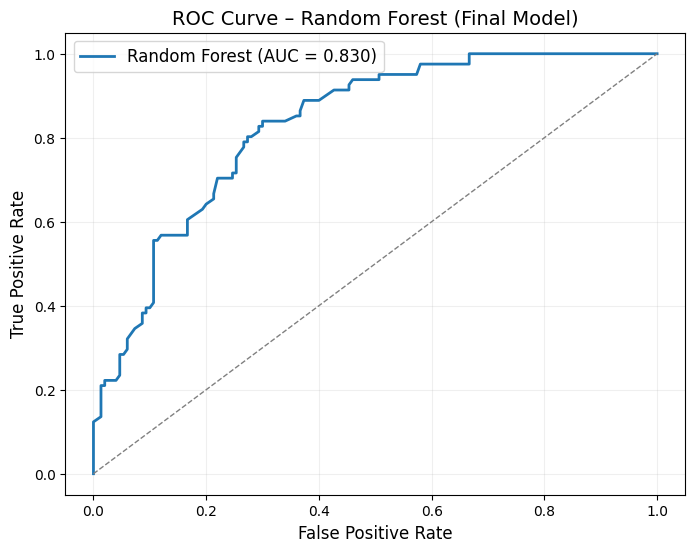

In [15]:
# -------------------------------------------------------------
# ROC CURVE FOR FINAL RANDOM FOREST MODEL
# -------------------------------------------------------------
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve – Random Forest (Final Model)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.2)

plt.show()


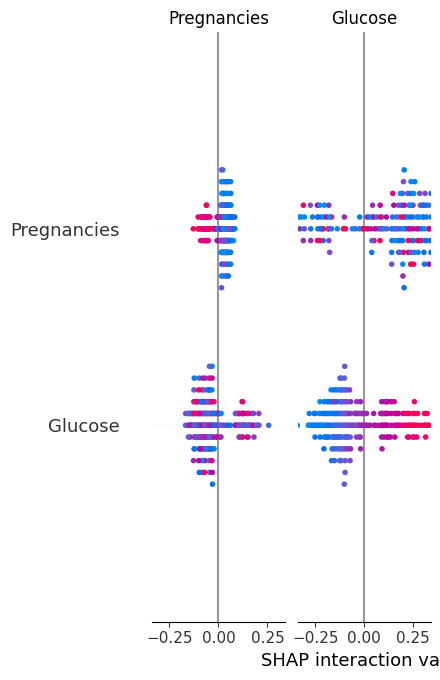

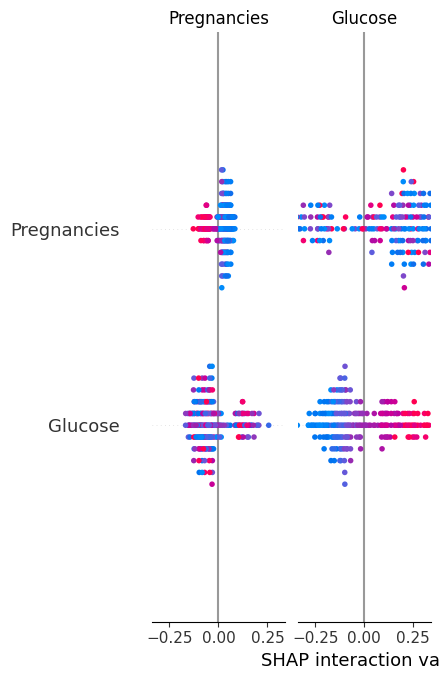

In [16]:
# -------------------------------------------------------------
# SHAP EXPLANATIONS FOR RANDOM FOREST
# -------------------------------------------------------------
import shap

# Convert X_test_scaled to numpy if needed
X_shap = X_test_scaled.values if hasattr(X_test_scaled, "values") else X_test_scaled

# Create SHAP explainer (TreeExplainer is optimized for tree models)
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_shap)

# RandomForestClassifier returns shap_values as [class0, class1]
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_class1 = shap_values[1]   # use the positive-class SHAP values
else:
    shap_class1 = shap_values      # fallback for single-output models

# -------------------------------------------------------------
# BAR SUMMARY PLOT (Global Feature Importance)
# -------------------------------------------------------------
shap.summary_plot(
    shap_class1,
    X_shap,
    feature_names=X.columns,
    plot_type="bar",
    show=True
)

# -------------------------------------------------------------
# OPTIONAL (Recommended for publication):
# DETAILED SUMMARY PLOT (beeswarm)
# -------------------------------------------------------------
shap.summary_plot(
    shap_class1,
    X_shap,
    feature_names=X.columns,
    show=True
)


In [17]:
# -------------------------------------------------------------
# SAVE SHAP FIGURE (BAR SUMMARY)
# -------------------------------------------------------------
import matplotlib.pyplot as plt
import os

# Ensure results directory exists
os.makedirs(dirs["results"], exist_ok=True)

# SHAP summary plot does not return a figure handle automatically,
# so capture the current figure AFTER plotting
plt.figure(figsize=(8,6))
shap.summary_plot(
    shap_class1,
    X_shap,
    feature_names=X.columns,
    plot_type="bar",
    show=False  # Prevents SHAP from immediately showing the figure
)

# Save SHAP figure
shap_path = os.path.join(dirs["results"], "SHAP_RF_Feature_Importance.png")
plt.savefig(shap_path, dpi=300, bbox_inches="tight")
plt.close()

print("SHAP bar plot saved to:", shap_path)

# -------------------------------------------------------------
# SAVE ML CROSS-VALIDATION RESULTS TABLE
# -------------------------------------------------------------
# Use the real values from earlier results_df (do NOT hardcode)
ml_cv_results = results_df.copy()

ml_results_path = os.path.join(dirs["results"], "ML_CV_Results.csv")
ml_cv_results.to_csv(ml_results_path, index=False)

print("ML CV results saved to:", ml_results_path)

ml_cv_results


SHAP bar plot saved to: /content/drive/MyDrive/ML_CRISPR_Diabetes/results/SHAP_RF_Feature_Importance.png
ML CV results saved to: /content/drive/MyDrive/ML_CRISPR_Diabetes/results/ML_CV_Results.csv


,Model,CV_Accuracy_Mean,CV_Accuracy_SD,Test_Accuracy,Test_AUC,Test_F1
0,LogReg,0.754286,0.036027,0.761905,0.838930,0.670659
1,RandomForest,0.830000,0.064111,0.740260,0.830206,0.638554
2,XGBoost,0.810000,0.062368,0.740260,0.808395,0.615385


<Figure size 800x600 with 0 Axes>

In [20]:
import pandas as pd
import os

CRISPR_DIR = dirs["crispr"]
fname = "aax9249_table_s1.xlsx"

fpath = os.path.join(CRISPR_DIR, fname)
xls = pd.ExcelFile(fpath)

# Load first sheet (Table S1 usually stores everything in one sheet)
df_raw = pd.read_excel(xls, sheet_name=xls.sheet_names[0])

print("Columns detected in Table S1:", list(df_raw.columns))

# --------------------------------------------------------
# DETECT CORRECT SEQUENCE + ACTIVITY COLUMNS FOR THIS FILE
# --------------------------------------------------------

# Your file's sequence column:
seq_col = "Target context sequence (4+20+3+3)"  # detected

# Your file's best activity column:
# The "background subtracted indel (%)" is the most reliable measurement.
act_col = "Background subtracted indel (%)"     # detected

print("Using sequence column:", seq_col)
print("Using activity column:", act_col)

# --------------------------------------------------------
# CLEAN + EXTRACT 20bp PROTOSPACER
# Given format: 4 bp + 20 bp + 3 bp + 3 bp = 30 bp
# Protospacer = positions [4:24]
# --------------------------------------------------------
df_raw["guide_seq"] = (
    df_raw[seq_col]
    .astype(str)
    .str.replace(" ", "")
    .str.upper()
    .str[4:24]
)

df_raw["activity_score"] = pd.to_numeric(df_raw[act_col], errors="coerce")

# --------------------------------------------------------
# FILTER VALID GUIDES
# --------------------------------------------------------
crispr_full = df_raw[["guide_seq", "activity_score"]].dropna()

# keep only correct 20bp
crispr_full = crispr_full[crispr_full["guide_seq"].str.len() == 20]

# remove sequences with ambiguous bases
valid_bases = set("ACGT")
crispr_full = crispr_full[
    crispr_full["guide_seq"].apply(lambda s: set(s).issubset(valid_bases))
]

print("\n✔ Final cleaned DeepSpCas9 dataset loaded from Table S1!")
print("Final shape:", crispr_full.shape)
crispr_full.head()


Columns detected in Table S1: ['Barcode', 'Target context sequence (4+20+3+3)', 'Total read count (Day 0)', 'Indel read count\n(Day 0)', 'Background\nindel frequencies (%)', 'Total read count\n(Day 2.9)', 'Indel read count\n(Day 2.9)', 'Indel frequencies (%)', 'Background subtracted indel (%)']
Using sequence column: Target context sequence (4+20+3+3)
Using activity column: Background subtracted indel (%)

✔ Final cleaned DeepSpCas9 dataset loaded from Table S1!
Final shape: (12832, 2)


,guide_seq,activity_score
0,GCCTTGTTTCTTTCCTCTCT,24.287805
1,CCTTCAGCTCAGTGACAGTG,69.500438
2,CGACGACTACAATAAGCCTC,25.994760
3,CAAACTGACGGAGAACCTTG,57.964590
4,CAGATATCCGTGAAGGCTCT,39.355020


In [22]:
out_crispr_csv = os.path.join(CRISPR_DIR, "crispr_activity_clean.csv")
crispr_full.to_csv(out_crispr_csv, index=False)
out_crispr_csv


'/content/drive/MyDrive/ML_CRISPR_Diabetes/data/raw/CRISPR/crispr_activity_clean.csv'

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load cleaned DeepSpCas9 dataset (12,832 guides)
crispr = pd.read_csv(out_crispr_csv)

# -----------------------------
# One-hot encoding (A,C,G,T)
# -----------------------------
bases = ["A", "C", "G", "T"]
base_to_idx = {b: i for i, b in enumerate(bases)}

def one_hot_encode(seq):
    arr = np.zeros((len(seq), len(bases)))
    for i, ch in enumerate(seq):
        if ch in base_to_idx:
            arr[i, base_to_idx[ch]] = 1
    return arr.flatten()

X_crispr = np.vstack([one_hot_encode(s) for s in crispr["guide_seq"]])
y_crispr = crispr["activity_score"].values

# -----------------------------
# Train/Test Split
# -----------------------------
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_crispr, y_crispr, test_size=0.2, random_state=42
)

# -----------------------------
# Random Forest Regression
# -----------------------------
rf_reg = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train_c, y_train_c)

# -----------------------------
# Evaluation
# -----------------------------
y_pred_c = rf_reg.predict(X_test_c)

print("=== Random Forest CRISPR Efficiency Model ===")
print("R² Score:", r2_score(y_test_c, y_pred_c))
print("RMSE:", np.sqrt(mean_squared_error(y_test_c, y_pred_c)))
print("MAE:", mean_absolute_error(y_test_c, y_pred_c))


=== Random Forest CRISPR Efficiency Model ===
R² Score: 0.42309320097524805
RMSE: 17.60127757381008
MAE: 14.221838986873337


In [37]:
from sklearn.model_selection import cross_val_score, KFold

# 5-fold CV on the full dataset
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

rf_cv_r2 = cross_val_score(
    rf_reg,
    X_crispr, y_crispr,
    cv=kfold,
    scoring="r2",
    n_jobs=-1
)

print("=== Random Forest – 5-Fold Cross-Validation ===")
print("Mean R²:", np.round(rf_cv_r2.mean(), 4))
print("SD R²:", np.round(rf_cv_r2.std(), 4))


=== Random Forest – 5-Fold Cross-Validation ===
Mean R²: 0.4296
SD R²: 0.0062


In [38]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_reg.fit(X_train_c, y_train_c)
y_pred_xgb = xgb_reg.predict(X_test_c)

print("\n=== XGBoost CRISPR Efficiency Model ===")
print("R²:", r2_score(y_test_c, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test_c, y_pred_xgb)))
print("MAE:", np.mean(np.abs(y_test_c - y_pred_xgb)))

# 5-fold CV for XGBoost
xgb_cv_r2 = cross_val_score(
    xgb_reg,
    X_crispr, y_crispr,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

print("\n=== XGBoost – 5-Fold Cross-Validation ===")
print("Mean R²:", np.round(xgb_cv_r2.mean(), 4))
print("SD R²:", np.round(xgb_cv_r2.std(), 4))



=== XGBoost CRISPR Efficiency Model ===
R²: 0.5334351882290276
RMSE: 15.828776751220023
MAE: 12.62682590904675

=== XGBoost – 5-Fold Cross-Validation ===
Mean R²: 0.543
SD R²: 0.0196


In [39]:
import joblib
joblib.dump(rf_reg, os.path.join(CRISPR_DIR, "RF_CRISPR_model.joblib"))
joblib.dump(xgb_reg, os.path.join(CRISPR_DIR, "XGB_CRISPR_model.joblib"))


['/content/drive/MyDrive/ML_CRISPR_Diabetes/data/raw/CRISPR/XGB_CRISPR_model.joblib']

In [24]:
from Bio import SeqIO
import os

demo_fasta_path = os.path.join(CRISPR_DIR, "TCF7L2_region.fasta")
demo_seq = """>TCF7L2_demo_region
ATGCGTACGTTGACCTGACTGAGGCTTCCGATCGTAGCTAGCTGATCGATCGATCGTAGCTGACTG
CGTAGCTAGCTAGGATCGATCGATGCTAGCTAGCTGACTGACTGAGGCTAGCTAGGATCGATCGAT
"""

os.makedirs(os.path.dirname(demo_fasta_path), exist_ok=True)
with open(demo_fasta_path, "w") as f:
    f.write(demo_seq)

demo_fasta_path


'/content/drive/MyDrive/ML_CRISPR_Diabetes/data/raw/CRISPR/TCF7L2_region.fasta'

In [25]:
record = next(SeqIO.parse(demo_fasta_path, "fasta"))
seq = str(record.seq).upper()
len(seq), seq[:60]


(132, 'ATGCGTACGTTGACCTGACTGAGGCTTCCGATCGTAGCTAGCTGATCGATCGATCGTAGC')

In [26]:
from Bio.Seq import Seq

def find_ngg_guides_full(sequence, window=20):
    """
    Extracts all 20bp guides with NGG PAM on BOTH strands.

    Returns a list of dictionaries:
    {
        'guide': 20bp protospacer,
        'pam': 'NGG',
        'start': genomic_start,
        'end': genomic_end,
        'strand': '+' or '-'
    }
    """
    sequence = sequence.upper()
    rc_sequence = str(Seq(sequence).reverse_complement())
    guides = []

    # ---------------------------
    # FORWARD STRAND: N(20)+NGG
    # ---------------------------
    for i in range(len(sequence) - window - 2):
        protospacer = sequence[i:i+window]
        pam = sequence[i+window:i+window+3]

        # PAM must be exactly NGG
        if len(pam) == 3 and pam[1:] == "GG":
            guides.append({
                "guide": protospacer,
                "pam": pam,
                "start": i,
                "end": i + window,
                "strand": "+"
            })

    # ------------------------------
    # REVERSE STRAND: CCN + N(20)
    # Equivalent to NGG on reverse complement
    # ------------------------------
    for i in range(len(rc_sequence) - window - 2):
        protospacer = rc_sequence[i:i+window]
        pam = rc_sequence[i+window:i+window+3]

        # Reverse PAM (complement of NGG) = CCN
        if len(pam) == 3 and pam[:2] == "CC":
            # Convert RC coordinates → original coordinates
            rc_start = i
            rc_end = i + window

            orig_end = len(sequence) - rc_start
            orig_start = orig_end - window

            guides.append({
                "guide": protospacer,
                "pam": pam,
                "start": orig_start,
                "end": orig_end,
                "strand": "-"
            })

    return guides


In [27]:
guides = find_ngg_guides_full(seq)
len(guides), guides[:5]


(6,
 [{'guide': 'TGCGTACGTTGACCTGACTG',
   'pam': 'AGG',
   'start': 1,
   'end': 21,
   'strand': '+'},
  {'guide': 'AGCTGACTGCGTAGCTAGCT',
   'pam': 'AGG',
   'start': 57,
   'end': 77,
   'strand': '+'},
  {'guide': 'GCTAGCTAGCTGACTGACTG',
   'pam': 'AGG',
   'start': 90,
   'end': 110,
   'strand': '+'},
  {'guide': 'CTGACTGACTGAGGCTAGCT',
   'pam': 'AGG',
   'start': 99,
   'end': 119,
   'strand': '+'},
  {'guide': 'GCTAGCTAGCATCGATCGAT',
   'pam': 'CCT',
   'start': 80,
   'end': 100,
   'strand': '-'}])

In [28]:
import numpy as np
import pandas as pd

# --------------------------
# Utility: GC content
# --------------------------
def gc_content(s):
    return (s.count("G") + s.count("C")) / len(s)

# --------------------------
# Extract sequences & encode
# --------------------------
guide_seqs = [g["guide"] for g in guides]

X_guides = np.vstack([one_hot_encode(s) for s in guide_seqs])
eff_pred = rf_reg.predict(X_guides)

# --------------------------
# Build guide dataframe
# --------------------------
guides_df = pd.DataFrame(guides)
guides_df["efficiency_raw"] = eff_pred
guides_df["gc"] = guides_df["guide"].apply(gc_content)

# --------------------------
# Normalize efficiency (0–1)
# --------------------------
min_e = guides_df["efficiency_raw"].min()
max_e = guides_df["efficiency_raw"].max()

guides_df["efficiency_norm"] = (guides_df["efficiency_raw"] - min_e) / (max_e - min_e + 1e-9)

# Sort by predicted efficiency
guides_df = guides_df.sort_values("efficiency_raw", ascending=False).reset_index(drop=True)

guides_df.head()


,guide,pam,start,end,strand,efficiency_raw,gc,efficiency_norm
0,TGCGTACGTTGACCTGACTG,AGG,1,21,+,60.753795,0.55,1.000000
1,GCTAGCTAGCTGACTGACTG,AGG,90,110,+,58.417495,0.55,0.915412
2,CAGCTAGCTACGATCGGAAG,CCT,24,44,-,49.687558,0.55,0.599336
3,AGCTGACTGCGTAGCTAGCT,AGG,57,77,+,36.747390,0.55,0.130824
4,CTGACTGACTGAGGCTAGCT,AGG,99,119,+,35.771209,0.55,0.095480


In [30]:
from Bio.Seq import Seq

def hamming_distance(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

def off_target_score_local(guide, sequence, window=20, max_mismatches=3):
    guide_rc = str(Seq(guide).reverse_complement())
    hits = 0

    for i in range(len(sequence) - window + 1):
        cand = sequence[i:i+window]

        if len(cand) != window:
            continue

        forward_match = hamming_distance(guide, cand)
        reverse_match = hamming_distance(guide_rc, cand)

        # Count only OFF-targets (not perfect match)
        if (0 < forward_match <= max_mismatches) or (0 < reverse_match <= max_mismatches):
            hits += 1

    return hits


In [31]:
off_targets = [off_target_score_local(g["guide"], seq) for g in guides]

guides_df["offtarget_raw"] = off_targets


In [32]:
guides_df.head()


,guide,pam,start,end,strand,efficiency_raw,gc,efficiency_norm,offtarget_raw
0,TGCGTACGTTGACCTGACTG,AGG,1,21,+,60.753795,0.55,1.000000,0
1,GCTAGCTAGCTGACTGACTG,AGG,90,110,+,58.417495,0.55,0.915412,0
2,CAGCTAGCTACGATCGGAAG,CCT,24,44,-,49.687558,0.55,0.599336,0
3,AGCTGACTGCGTAGCTAGCT,AGG,57,77,+,36.747390,0.55,0.130824,0
4,CTGACTGACTGAGGCTAGCT,AGG,99,119,+,35.771209,0.55,0.095480,2


In [33]:
min_ot = guides_df["offtarget_raw"].min()
max_ot = guides_df["offtarget_raw"].max()

if max_ot == min_ot:
    guides_df["offtarget_norm"] = 0.0
else:
    guides_df["offtarget_norm"] = (guides_df["offtarget_raw"] - min_ot) / (max_ot - min_ot)


In [34]:
alpha, beta, gamma = 0.4, 0.4, 0.2   # (GWAS, efficiency, off-target)

guides_df["GWAS_gene_weight"] = gwas_gene_weight

guides_df["IS"] = (
    alpha * guides_df["GWAS_gene_weight"] +
    beta  * guides_df["efficiency_norm"] -
    gamma * guides_df["offtarget_norm"]
)

guides_ranked = guides_df.sort_values("IS", ascending=False)
guides_ranked.head(10)


,guide,pam,start,end,strand,efficiency_raw,gc,efficiency_norm,offtarget_raw,offtarget_norm,GWAS_gene_weight,IS
0,TGCGTACGTTGACCTGACTG,AGG,1,21,+,60.753795,0.55,1.000000,0,0.0,0.950789,0.780316
1,GCTAGCTAGCTGACTGACTG,AGG,90,110,+,58.417495,0.55,0.915412,0,0.0,0.950789,0.746481
2,CAGCTAGCTACGATCGGAAG,CCT,24,44,-,49.687558,0.55,0.599336,0,0.0,0.950789,0.620050
3,AGCTGACTGCGTAGCTAGCT,AGG,57,77,+,36.747390,0.55,0.130824,0,0.0,0.950789,0.432645
5,GCTAGCTAGCATCGATCGAT,CCT,80,100,-,33.134079,0.50,0.000000,0,0.0,0.950789,0.380316
4,CTGACTGACTGAGGCTAGCT,AGG,99,119,+,35.771209,0.55,0.095480,2,1.0,0.950789,0.218508


In [35]:
out_guides_path = os.path.join(dirs["results"], "TCF7L2_demo_guides_ranked_IS.csv")
guides_ranked.to_csv(out_guides_path, index=False)
out_guides_path


'/content/drive/MyDrive/ML_CRISPR_Diabetes/results/TCF7L2_demo_guides_ranked_IS.csv'

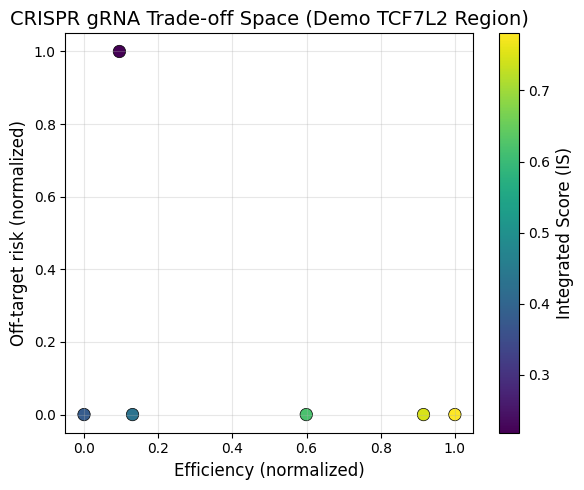

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))

scatter = plt.scatter(
    guides_df["efficiency_norm"],
    guides_df["offtarget_norm"],
    c=guides_df["IS"],
    s=80,
    cmap="viridis",
    edgecolor="black",
    linewidth=0.5
)

plt.xlabel("Efficiency (normalized)", fontsize=12)
plt.ylabel("Off-target risk (normalized)", fontsize=12)
plt.title("CRISPR gRNA Trade-off Space (Demo TCF7L2 Region)", fontsize=14)

cbar = plt.colorbar(scatter)
cbar.set_label("Integrated Score (IS)", fontsize=12)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
